In [9]:
!export PYTHONPATH=$PYTHONPATH:$PWD/..:$PWD

In [1]:
import torch
from hydra.utils import instantiate
from hydra import initialize, compose
import hydra
import matplotlib.pyplot as plt

from PhaseClassifier import logging
logger = logging.getLogger(__name__)

from PhaseClassifier.scripts.run import setup_model, load_model_instance

[12:56:18.930] INFO   PhaseClassifier                                   Loading configuration.


In [23]:
hydra.core.global_hydra.GlobalHydra.instance().clear()
initialize(version_base=None, config_path="PhaseClassifier/config")
config=compose(config_name="config.yaml")

In [24]:
# self = setup_model(config)
new_model = False
if new_model:
    self = setup_model(config)
    # self.model = self.model.double()  # sets all model parameters to float64
else:
    self = load_model_instance(config, False)
    # self.model = self.model.double()

[13:09:05.458] INFO   data.dataManager                                  Loading dataset: Ising
[13:09:05.459] INFO   data.dataManager                                  Keys: ['Label', 'Snapshot', 'Temperature']
[13:09:05.586] INFO   data.dataManager                                  dict_keys(['Label', 'Snapshot', 'Temperature'])
[13:09:05.634] INFO   data.dataManager                                  <torch.utils.data.dataloader.DataLoader object at 0x7f1f722f03e0>: 32000 events, 64 batches
[13:09:05.634] INFO   data.dataManager                                  <torch.utils.data.dataloader.DataLoader object at 0x7f1ef0378290>: 4000 events, 4 batches
[13:09:05.634] INFO   data.dataManager                                  <torch.utils.data.dataloader.DataLoader object at 0x7f1f722f0770>: 4000 events, 4 batches
[13:09:05.635] INFO   model.modelCreator                                ::Creating Model
[13:09:05.638] INFO   PhaseClassifier.scripts.run                       Requesting GPUs. GPU 

cuda:2
Loading weights for module =  seq
Loading weights for module =  lm_head1
Loading weights for module =  sa_head
Loading weights for module =  lm_head2
Loading weights for module =  conv


In [25]:
# collect all labels from the test loader into a single 1D tensor (on CPU)
self.model.eval()
with torch.no_grad():
    pred_list = []
    temp_list = []
    for (x,y,t) in self.data_mgr.test_loader:
        x = x.to(self.device)
        pred = self.model(x)
        pred_list.append(F.softmax(pred).argmax(dim=1).cpu())
        temp_list.append(t[:,0].cpu())
    test_preds = torch.cat(pred_list, dim=0)
    test_temps = torch.cat(temp_list, dim=0)

# example: print basic info
print("test_labels shape:", test_preds.shape, "unique labels:", torch.unique(test_preds))
print("test_temps shape:", test_temps.shape)

test_labels shape: torch.Size([4000]) unique labels: tensor([0, 1])
test_temps shape: torch.Size([4000])


/tmp/ipykernel_1902046/3103514412.py:9: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  pred_list.append(F.softmax(pred).argmax(dim=1).cpu())


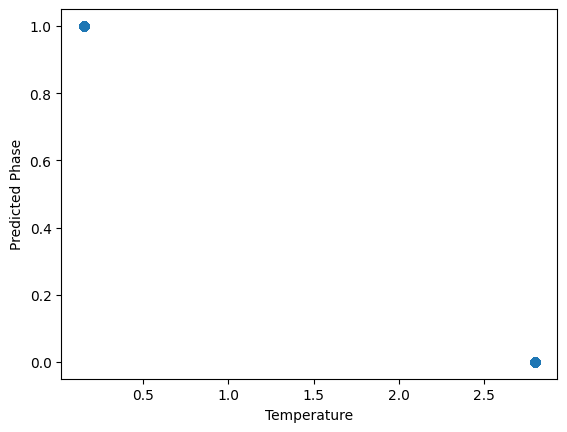

In [27]:
plt.scatter( test_temps, test_preds)
plt.xlabel('Temperature')
plt.ylabel('Predicted Phase')
plt.show()